In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## NewYork City Bike

在预测模型训练之前对数据进行清洗， 数据清洗的代码已经整理在 `citibikeUtil.py`中，预测器的代码已经整理在`predictor.py`中，
`citybikeDraw.py`是用来生成图片的文件 `citybikeMetrics.py`计算指标

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
from citybikeUtil import CB201808, CB201809, CB201810, CB201811, CB201812, CB201901, CB201902
from predictor import LSTMPredictor, DecisionTreePredictor, XGBoostPredictor

Using TensorFlow backend.


## LSTMPredictor

In [5]:
lstm_predictor = LSTMPredictor()
lstm_predictor.train_month = CB201808

### 训练模型

In [6]:
train_x, train_y = lstm_predictor.get_train_vec(CB201808)
test_x, test_y = lstm_predictor.get_train_vec(CB201809)
lstm_predictor.train_model(train_x, train_y)
predict_y = lstm_predictor.model.predict(test_x)

./201808-citibike-tripdata.csv.lstm.h5


### 预测值和真实值都需要reshape (707,1)->(1,707)

In [7]:
len(predict_y), len(test_y)

(707, 707)

### 根据预测结果的个数生成 时间间隔 

预测月份是9月份 因为需要生成13点的向量 需要收集前12点的数据 所以从13点开始 看到预测结果的个数是707 所以periods参数为707 表示生成707个周期的结果 freq代表频率 'H'代表小时 每小时生成一个

### 使用seaborn画图需要将数据合成df

In [8]:
date_index = pd.date_range(start='2018-09-01 13:00:00', periods=707, freq='H')
merge_data = {
    'predict': predict_y.flatten(),
    'real': test_y.flatten()
}
lstm_df = pd.DataFrame(merge_data, index=date_index)

In [9]:
date_index.tolist()

[Timestamp('2018-09-01 13:00:00', freq='H'),
 Timestamp('2018-09-01 14:00:00', freq='H'),
 Timestamp('2018-09-01 15:00:00', freq='H'),
 Timestamp('2018-09-01 16:00:00', freq='H'),
 Timestamp('2018-09-01 17:00:00', freq='H'),
 Timestamp('2018-09-01 18:00:00', freq='H'),
 Timestamp('2018-09-01 19:00:00', freq='H'),
 Timestamp('2018-09-01 20:00:00', freq='H'),
 Timestamp('2018-09-01 21:00:00', freq='H'),
 Timestamp('2018-09-01 22:00:00', freq='H'),
 Timestamp('2018-09-01 23:00:00', freq='H'),
 Timestamp('2018-09-02 00:00:00', freq='H'),
 Timestamp('2018-09-02 01:00:00', freq='H'),
 Timestamp('2018-09-02 02:00:00', freq='H'),
 Timestamp('2018-09-02 03:00:00', freq='H'),
 Timestamp('2018-09-02 04:00:00', freq='H'),
 Timestamp('2018-09-02 05:00:00', freq='H'),
 Timestamp('2018-09-02 06:00:00', freq='H'),
 Timestamp('2018-09-02 07:00:00', freq='H'),
 Timestamp('2018-09-02 08:00:00', freq='H'),
 Timestamp('2018-09-02 09:00:00', freq='H'),
 Timestamp('2018-09-02 10:00:00', freq='H'),
 Timestamp

In [10]:
import json

In [11]:
merge_data = {
    'predict': predict_y.flatten().tolist(),
    'real': test_y.flatten().tolist(),
    "time": date_index.tolist()
}

# 实验结果

## 预测结果图展示
因为一个月的太长了，只显示调整为1周

In [12]:
sns.set(style="whitegrid")
sns.set_context(rc={"lines.linewidth": 2})

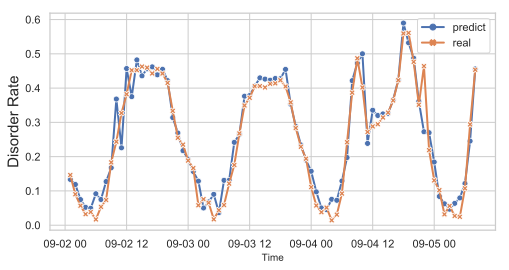

In [13]:
# plt.figure(figsize=(15, 5))
f, ax = plt.subplots(figsize = (8, 4))
# 设置图名称
# ax.set_title('DataStream DisOrder Predict - 1st Week', fontsize=15)
# 设置X轴 Y轴 的label
ax.set_xlabel('Time',fontsize=10)
ax.set_ylabel('Disorder Rate',fontsize=15)
sns.lineplot(size='event',
             markers=True,dashes=False,
             data=lstm_df[12:92])
plt.savefig('lstm-bike.eps',bbox_inches='tight',format='eps')

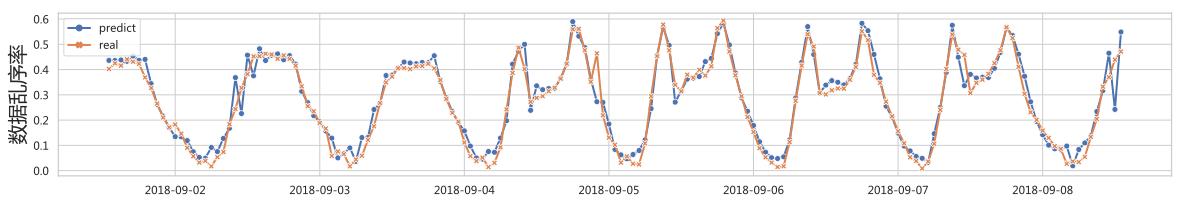

In [17]:
# plt.figure(figsize=(15, 5))
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft Yahei']
f, ax = plt.subplots(figsize = (20, 3))
# 设置图名称
# ax.set_title('DataStream DisOrder Predict - 1st Week', fontsize=15)
# 设置X轴 Y轴 的label
# ax.set_xlabel('时间',fontsize=15)
ax.set_ylabel('数据乱序率',fontsize=20)
sns.lineplot(size='event',
             markers=True,dashes=False,
             data=lstm_df[:169])
plt.savefig('单车预测结果-lstm.pdf',bbox_inches='tight',format='pdf')

## 导出eps

## 封装成一个画图类

In [11]:
from citybikeDraw import DrawLSTM
draw = DrawLSTM()
draw.set_train_month(CB201808)
test_y, predict_y = draw.get_predict_result(CB201808, CB201809)

./201808-citibike-tripdata.csv.lstm.h5


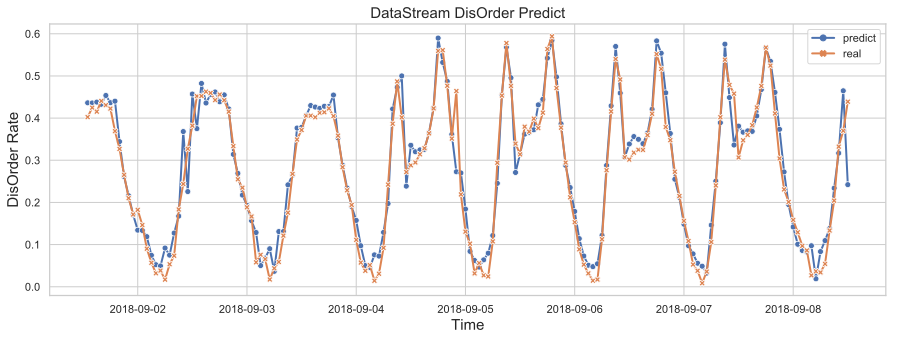

In [12]:
draw.draw_real_predict(
    week_num=1,
    start_time="2018-09-01 13:00:00",
    title="DataStream DisOrder Predict",
    figsize=(15,5)
)

## 回归性能指标

分月份展示:

比如训练 CB201808 预测 CB201809  均方根误差（标准误差）平均绝对误差  R-squared

比如训练 CB201809 预测 CB201810 均方根误差（标准误差）平均绝对误差  R-squared

### 均方根误差(Root Mean Squard Error，RMSE)

$RMSE=\sqrt{\frac{1}{m} \sum_{i=1}^{m}\left(f_{i}-y_{i}\right)^{2}}$

标准差是方差的算术平方根。标准误差是均方误差的算术平方根。
标准差是用来衡量一组数自身的离散程度，而均方根误差是用来衡量观测值同真值之间的偏差，它们的研究对象和研究目的不同，但是计算过程类似

它的意义在于开个根号后，误差的结果就与数据是一个级别的，可以更好地来描述数据。标准误差对一组测量中的特大或特小误差反映非常敏感，所以，标准误差能够很好地反映出测量的精密度。这正是标准误差在工程测量中广泛被采用的原因。

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np
np.sqrt(mean_squared_error(test_y, predict_y))

0.058415532

### 平均绝对误差(Mean Absolute Error，MAE)

$MAE=\frac{1}{m} \sum_{i=1}^{m}\left|f_{i}-y_{i}\right|$

平均绝对误差能更好地反映预测值误差的实际情况.

In [14]:
from sklearn.metrics import median_absolute_error
median_absolute_error(test_y, predict_y)

0.025616288

### R-squared
$R^{2}=1-\frac{\sum_{i=1}^{m}\left(f_{i}-y_{i}\right)^{2}}{\sum_{i=1}^{m}\left(\overline{y_{i}}-y_{i}\right)^{2}}$

上面分子就是我们训练出的模型预测的误差和。
下面分母就是瞎猜的误差和。（通常取观测值的平均值）

如果结果是0，就说明我们的模型跟瞎猜差不多。
如果结果是1。就说明我们模型无错误。

$R^2$介于0~1之间，越接近1，回归拟合效果越好，一般认为超过0.8的模型拟合优度比较高。


In [15]:
from sklearn.metrics import r2_score
r2_score(test_y, predict_y)

0.8872312936479068

## 统计每个月预测结果的回归性能指标

In [16]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [17]:
from citybikeMetrics import get_reg_metrics

In [20]:
months = [CB201808, CB201809, CB201810, CB201811, CB201812, CB201901, CB201902]

### 使用更新的模型

In [21]:
update_metrics = get_reg_metrics(months, True)

./201808-citibike-tripdata.csv.lstm.h5
./201809-citibike-tripdata.csv.lstm.h5
./201810-citibike-tripdata.csv.lstm.h5
./201811-citibike-tripdata.csv.lstm.h5
./201812-citibike-tripdata.csv.lstm.h5
./201901-citibike-tripdata.csv.lstm.h5


### 不使用更新的模型

In [22]:
unupdate_metrics = get_reg_metrics(months, False)

./201808-citibike-tripdata.csv.lstm.h5
./201808-citibike-tripdata.csv.lstm.h5
./201808-citibike-tripdata.csv.lstm.h5
./201808-citibike-tripdata.csv.lstm.h5
./201808-citibike-tripdata.csv.lstm.h5
./201808-citibike-tripdata.csv.lstm.h5


In [23]:
result = pd.concat([update_metrics,unupdate_metrics], axis=1)

In [24]:
result.columns = [["Update Model","Update Model","Update Model","UnUpdate","UnUpdate","UnUpdate"],["RMSE", "MAE", "R2S","RMSE", "MAE", "R2S"]]

In [25]:
result

Update Model                      UnUpdate                    
                   RMSE       MAE       R2S      RMSE       MAE       R2S
2018-09-01     0.058416  0.025616  0.887231  0.058416  0.025616  0.887231
2018-10-01     0.078540  0.029740  0.849027  0.086056  0.033229  0.818750
2018-11-01     0.074499  0.037202  0.905038  0.103220  0.064502  0.817706
2018-12-01     0.048297  0.027989  0.953111  0.078932  0.045365  0.874760
2019-01-01     0.048319  0.028885  0.952392  0.072062  0.042751  0.894106
2019-02-01     0.044274  0.024607  0.962902  0.081318  0.049124  0.874853

In [26]:
update_metrics

,mse,mae,r2s
2018-09-01,0.058416,0.025616,0.887231
2018-10-01,0.078540,0.029740,0.849027
2018-11-01,0.074499,0.037202,0.905038
2018-12-01,0.048297,0.027989,0.953111
2019-01-01,0.048319,0.028885,0.952392
2019-02-01,0.044274,0.024607,0.962902


In [27]:
unupdate_metrics

,mse,mae,r2s
2018-09-01,0.058416,0.025616,0.887231
2018-10-01,0.086056,0.033229,0.818750
2018-11-01,0.103220,0.064502,0.817706
2018-12-01,0.078932,0.045365,0.874760
2019-01-01,0.072062,0.042751,0.894106
2019-02-01,0.081318,0.049124,0.874853
